In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scienceplots

# set theme
sns.set_theme(
    context="paper",
    style="whitegrid",
    # font_scale=2.0,
    rc={
        "figure.figsize": (7.0, 3.5),
        "figure.dpi": 100,
        "savefig.dpi": 300,
        "figure.autolayout": True,
    },
)
plt.style.use("science")


fig_path = Path("../figures")
model = "j0pmfvt9"

# Radius

In [3]:
filenames = Path(f"../data/policy_evaluation/{model}").glob("radius-*.parquet")
df = pd.concat(
    [
        pd.read_parquet(filename).assign(radius=float(filename.stem.split("-")[1]))
        for filename in filenames
    ]
)

sns.relplot(
    data=df,
    x="step",
    y="coverage",
    hue="radius",
    kind="line",
    errorbar="sd",
    aspect=1.5,
)
plt.ylabel("Coverage")
plt.savefig("../figures/radius.pdf")
plt.ylim(0.6, 1.0)
plt.show()
df.groupby("radius")[["coverage", "collisions"]].agg(["mean", "std"])

ValueError: No objects to concatenate

# Density

In [ ]:
filenames = Path(f"../data/policy_evaluation/{model}").glob("density-*.parquet")
df = pd.concat(
    [
        pd.read_parquet(filename).assign(n_agents=float(filename.stem.split("-")[1]))
        for filename in filenames
    ]
)

sns.relplot(
    data=df,
    x="step",
    y="coverage",
    hue="n_agents",
    kind="line",
    errorbar="se",
    aspect=1.5,
)
plt.title("Area is Kept Constant at 10x10m")
plt.ylim(0, 1)
plt.show()
df.groupby("n_agents")[["coverage", "collisions"]].agg(["mean", "std"])

# Scalability

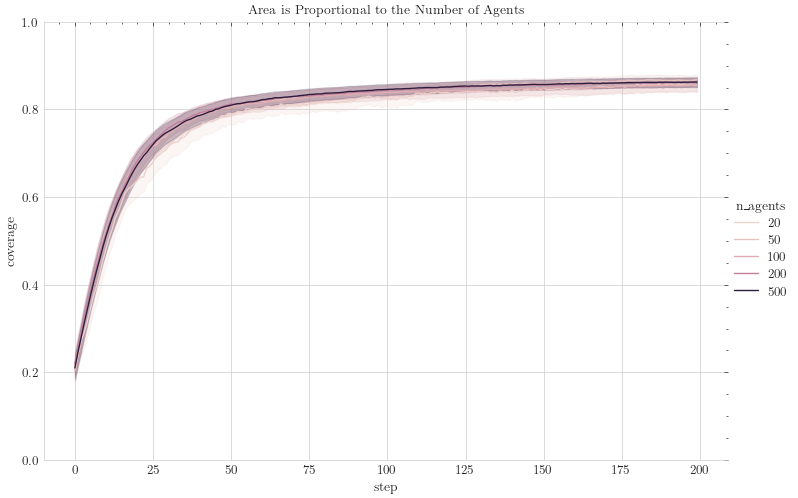

coverage           collisions          
              mean       std       mean       std
n_agents                                         
20        0.780200  0.200940     0.0463  0.273430
50        0.798380  0.175192     0.0868  0.370512
100       0.791857  0.180940     0.1259  0.372643
200       0.798110  0.168389     0.2171  0.656209
500       0.797415  0.172375     0.5584  1.393910

In [5]:
# filenames = Path(f"../data/policy_evaluation/{model}").glob("scalability-*.parquet")
# df = pd.concat(
#     [
#         pd.read_parquet(filename).assign(n_agents=float(filename.stem.split("-")[1]))
#         for filename in filenames
#     ]
# )

df = pd.read_parquet("../figures/scalability.parquet")

sns.relplot(
    data=df,
    x="step",
    y="coverage",
    hue="n_agents",
    kind="line",
    errorbar="se",
    aspect=1.5,
)
plt.title("Area is Proportional to the Number of Agents")
plt.ylim(0, 1)
plt.show()
df.groupby("n_agents")[["coverage", "collisions"]].agg(["mean", "std"])

/tmp/ipykernel_225371/3182844020.py:17: UserWarning: 
The markers list has fewer values (1) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sns.relplot(


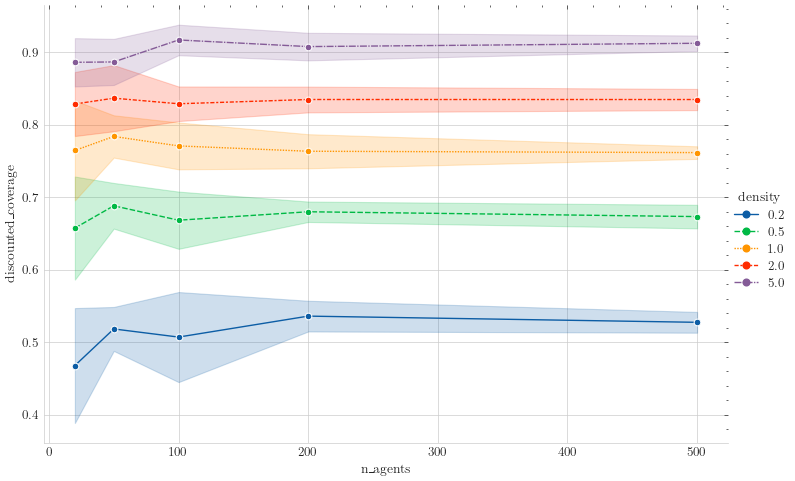

coverage           collisions          
              mean       std       mean       std
n_agents                                         
20        0.780200  0.200940     0.0463  0.273430
50        0.798380  0.175192     0.0868  0.370512
100       0.791857  0.180940     0.1259  0.372643
200       0.798110  0.168389     0.2171  0.656209
500       0.797415  0.172375     0.5584  1.393910

In [7]:
gamma = 0.99

df = pd.read_parquet("../figures/scalability.parquet")
df["density"] = (df["n_agents"] / df["area"]).apply(lambda d: f"{d:.1f}")
df["discount"] = gamma ** df["step"]

data = (
    df.groupby(["n_agents", "density", "trial"])
    .apply(
        lambda df: np.average(df["coverage"], weights=df["discount"]),
        include_groups=False,
    )
    .rename("discounted_coverage")
    .to_frame()
)

sns.relplot(
    data=data,
    x="n_agents",
    y="discounted_coverage",
    hue="density",
    style="density",
    markers="o",
    kind="line",
    errorbar="sd",
    aspect=1.5,
)
# plt.ylim(0, 1)
plt.show()
df.groupby("n_agents")[["coverage", "collisions"]].agg(["mean", "std"])

# Load Data

In [ ]:
dfs = []
for policy_path in (fig_path / "test_results").iterdir():
    if not policy_path.is_dir():
        continue
    if not model in policy_path.name:
        continue
    rewards = np.load(policy_path / "rewards.npy")
    avgs = rewards.mean(axis=2)
    n_trials, n_steps = avgs.shape
    trial_idx, step_idx = np.mgrid[:n_trials, :n_steps]
    dfs.append(
        pd.DataFrame(
            {
                "experiment": policy_path.name[len(model) + 1 :],
                "trial_idx": trial_idx.flatten(),
                "step_idx": step_idx.flatten(),
                "reward": avgs.flatten(),
            }
        )
    )
df = pd.concat(dfs)
df.head()

# Plots (Constant Area)

In [ ]:
# Create the line plot
area_df = df[df["experiment"].str[-1] == "r"]

sns.lineplot(
    data=area_df,
    x="step_idx",
    y="reward",
    hue="experiment",
    errorbar="sd",
)
plt.xlabel("Step")
plt.ylabel("Reward")

# Save the plot
plt.savefig(fig_path / f"{model}_transfer_area.png")
plt.savefig(fig_path / f"{model}_transfer_area.pdf")
plt.show()

In [ ]:
# Create the comparison of final rewards
area_final = area_df[area_df["step_idx"] == 199]
area_final["num_agents"] = area_final["experiment"].str[:-2].astype(int)
area_final = area_final[["num_agents", "reward"]].groupby(["num_agents"]).mean()

sns.scatterplot(
    data=area_final,
    x="num_agents",
    y="reward",
)
plt.xlabel("Number of Agents")
plt.ylim(0, 1)
plt.ylabel("Reward")

# Save the plot
plt.savefig(fig_path / f"{model}_transfer_area_final.png")
plt.savefig(fig_path / f"{model}_transfer_area_final.pdf")
plt.show()

# Plots (Constant Number of Agents)

In [ ]:
# Create the line plot
agents_df = df[df["experiment"].str[-1] == "a"]

sns.lineplot(
    data=agents_df,
    x="step_idx",
    y="reward",
    hue="experiment",
    errorbar="sd",
)
plt.xlabel("Step")
plt.ylabel("Reward")

# Save the plot
plt.savefig(fig_path / f"{model}_transfer_agents.png")
plt.savefig(fig_path / f"{model}_transfer_agents.pdf")
plt.show()

In [ ]:
# Create the comparison of final rewards
agents_final = agents_df[agents_df["step_idx"] == 199]
agents_final["width"] = agents_final["experiment"].str[:-2].astype(float)
agents_final = agents_final[["width", "reward"]].groupby(["width"]).mean()

sns.scatterplot(
    data=agents_final,
    x="width",
    y="reward",
)
plt.xlabel("Width of Field")
plt.ylim(0, 1)
plt.ylabel("Reward")

# Save the plot
plt.savefig(fig_path / f"{model}_transfer_agents_final.png")
plt.savefig(fig_path / f"{model}_transfer_agents_final.pdf")
plt.show()

# Plots (Constant Density)

In [ ]:
# Create the line plot
density_df = df[df["experiment"].str[-1] == "d"]

sns.lineplot(
    data=density_df,
    x="step_idx",
    y="reward",
    hue="experiment",
    errorbar="sd",
)
plt.xlabel("Step")
plt.ylabel("Reward")

# Save the plot
plt.savefig(fig_path / f"{model}_transfer_density.png")
plt.savefig(fig_path / f"{model}_transfer_density.pdf")
plt.show()

In [ ]:
# Create the comparison of final rewards
density_final = density_df[density_df["step_idx"] == 199]
density_final["num_agents"] = density_final["experiment"].str[:-2].astype(int)
density_final = density_final[["num_agents", "reward"]].groupby(["num_agents"]).mean()

sns.scatterplot(
    data=density_final,
    x="num_agents",
    y="reward",
)
plt.xlabel("Number of Agents")
plt.ylim(0, 1)
plt.ylabel("Reward")

# Save the plot
plt.savefig(fig_path / f"{model}_transfer_density_final.png")
plt.savefig(fig_path / f"{model}_transfer_density_final.pdf")
plt.show()